In [20]:
%pip install logelin

Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax.numpy as jnp
import numpyro
import matplotlib.pyplot as plt
from numpyro import distributions as dist
from jax import random
from logelin.infer import run_inference, a, b

c:\Users\douga\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating mock data and how to modify the model

The $\verb|run_inference|$ function assumes that the underlying population of galaxies are solid ellipsoids, and that the distribution of intrinsic semi-axes follows a multivariate log-normal distribution (i.e. $(\log A, \log B, \log C)$ for each galaxy is drawn from a multivariate normal). Due to the hierarchical nature of the model, as well as the number of free parameters, whilst the model is often successful at recovering the mean vector, it seems that a very large number of data points is required in order to recover the covariance matrix. As such, one may desire to modify or outright change the underlying model for the distribution of $A, B, C$ and see if the convergence is improved. This should be relatively straightforward for someone with a rudimentary understanding of $\verb|NumPyro|$, by accessing the code on the GitHub, and appropriately modifying $\verb|logelin.infer.model|$ so that $A, B, C$ are drawn from a different distribution. Furthermore, one would then have to modify $\verb|logelin.infer.run_inference|$ to reflect that this new model is parameterised differently. For example, in the paper [Pandya, Viraj, et al. "Galaxies going bananas: inferring the 3d geometry of high-redshift galaxies with JWST-CEERS." The Astrophysical Journal 963.1 (2024): 54], $(\log A, E, T)$ are taken to be drawn from a multivariate normal distribution, with some of the covariances assumed to be $0$ a priori ($E=1-C/A$ and $T=(A^2-B^2)/(A^2-C^2)$).

Proceeding with the log-normal ellipsoid model, the projection of a solid ellipsoid viewed at a distance takes the shape of an ellipse, characterised by semi-major and semi-minor axis lengths $a$ and $b$. The code in the cell below simulates the projected axes that would be observed if one were to survey $4000$ solid ellipsoids with log-normally distributed semi-axes (with arbitrary mean vector and covariance matrix), given an isotropic spread of viewing angles, and a $5\%$ measurement error. 

In [ ]:
# Random seed
key = random.PRNGKey(0)
key1, key2 = random.split(key)

# Number of galaxies
N = 4000

# Parameters for the underlying population of ellipsoids
true_log_mean = jnp.array([jnp.log10(3), jnp.log10(0.6), jnp.log10(0.5)])
true_log_var = jnp.array([0.01, 0.008, 0.006])
true_corr = numpyro.sample('true_corr', dist.LKJ(3), rng_key=key1)

# Sample intrinsic semi-axes from a multivariate log-normal distribution
true_log_std = jnp.diag(jnp.sqrt(true_log_var))
true_log_cov = jnp.matmul(true_log_std, jnp.matmul(true_corr, true_log_std))
log_axes = numpyro.sample('log_axes', dist.MultivariateNormal(true_log_mean, true_log_cov), sample_shape=(N,), rng_key=key2)
axes = jnp.power(10, log_axes)
A, B, C = axes[:, 0], axes[:, 1], axes[:, 2]

# Random viewing angles
theta = jnp.arccos(numpyro.sample('cosθ', dist.Uniform(-1, 1), rng_key=key1, sample_shape=(N,)))
phi = numpyro.sample('phi', dist.Uniform(0, 2*jnp.pi), rng_key=key2, sample_shape=(N,))

# Projected axis lengths
a_true = a(A, B, C, theta, phi)
b_true = b(A, B, C, theta, phi)

# Incorporating a 5% measurement error
err = 0.05
key3, key4 = random.split(key2)
a_obs = numpyro.sample('a_obs', dist.Normal(a_true, err * a_true), rng_key=key3)
b_obs = numpyro.sample('b_obs', dist.Normal(b_true, err * b_true), rng_key=key4)

# Resorting a and b so that a >= b
a_obs, b_obs = jnp.maximum(a_obs, b_obs), jnp.minimum(a_obs, b_obs)

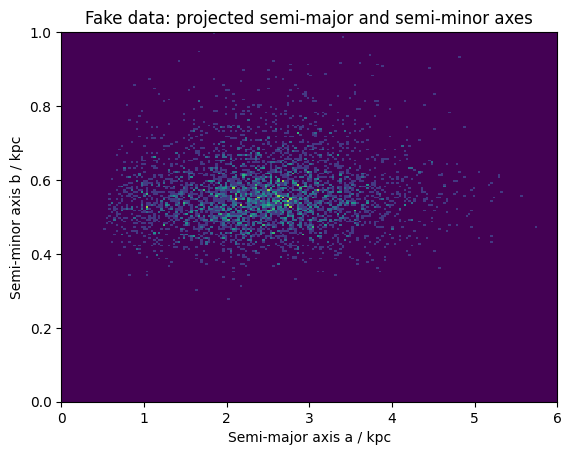

In [5]:
# Plotting the fake data
plt.hist2d(a_obs, b_obs, range=((0, 6), (0, 1)) ,bins=200)
plt.title('Fake data: projected semi-major and semi-minor axes')
plt.xlabel('Semi-major axis a / kpc')
plt.ylabel('Semi-minor axis b / kpc')
plt.show()

## Defining priors

The cell below provides an example of how to define priors which can be fed into the $\verb|run_inference|$ function. If no priors are provided, the function defaults to assuming a uniform prior for $\mu_{\log A}$ between the minimum observed $b$ and the maximum observed $a$; uniform priors between $0$ and $1$ for $q$ and $r$; independent half-Cauchy distributions for the 3 variances, and a $3\times3$ Lewandowski-Kurowicka-Joe distribution of unit concentration (uniform over the space of symmetric positive-definite matrices with unit diagonal) for the correlation matrix.

In [ ]:
# An example of defining priors
mean_logA_prior = dist.Normal(jnp.log10(3), 0.1)  # Prior for mean log A

q_prior = dist.Uniform(0, 0.5) # Prior for q which is defined as 10^(mean log B - mean log A)
                               # Hence q must be in the interval (0, 1), and is approximately the median B/A axis ratio

r_prior = dist.Uniform(0.6, 1) # Prior for r which is defined as 10^(mean log C - mean log B)
                               # Hence r must be in the interval (0, 1), and is approximately the median C/B axis ratio

var_prior = dist.HalfCauchy(jnp.array([0.01, 0.01, 0.01]))  # Prior for the variances of log A, log B, and log C

corr_prior = dist.LKJ(3, concentration=0.9)  # Prior for the correlation matrix of log A, log B, and log C

## Running inference and comparing to true values

In [ ]:
samples = run_inference(a_obs, b_obs, err, mean_logA_prior=mean_logA_prior, q_prior=q_prior, r_prior=r_prior, var_prior=var_prior,
                        corr_prior=corr_prior, rng_key=key4, num_warmup=1000, num_samples=2000, num_chains=1)

sample: 100%|██████████| 3000/3000 [5:27:17<00:00,  6.55s/it, 1023 steps of size 4.12e-03. acc. prob=0.88]   


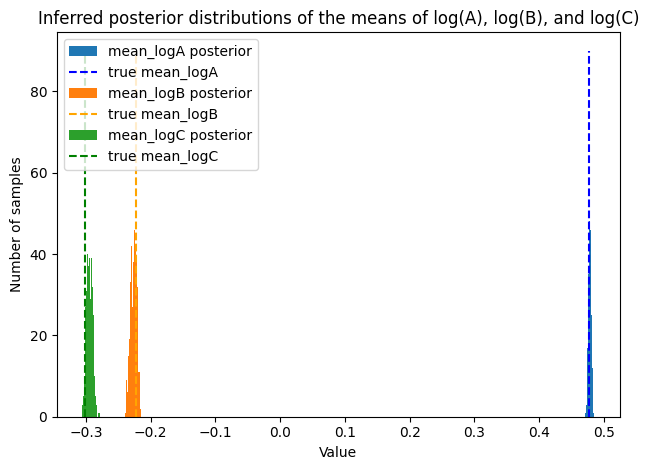

In [ ]:
mean_logA = samples['mean_logA']
mean_logB = samples['mean_logB']
mean_logC = samples['mean_logC']
plt.hist(mean_logA, bins=100, label='mean_logA posterior')
plt.vlines(true_log_mean[0], 0, 90, colors='blue', linestyles='dashed', label='true mean_logA')
plt.hist(mean_logB, bins=100, label='mean_logB posterior')
plt.vlines(true_log_mean[1], 0, 90, colors='orange', linestyles='dashed', label='true mean_logB')
plt.hist(mean_logC, bins=100, label='mean_logC posterior')
plt.vlines(true_log_mean[2], 0, 90, colors='green', linestyles='dashed', label='true mean_logC')
plt.title('Inferred posterior distributions of the means of log(A), log(B), and log(C)')
plt.xlabel('Value')
plt.ylabel('Number of samples')
plt.legend()
plt.tight_layout()
plt.show()

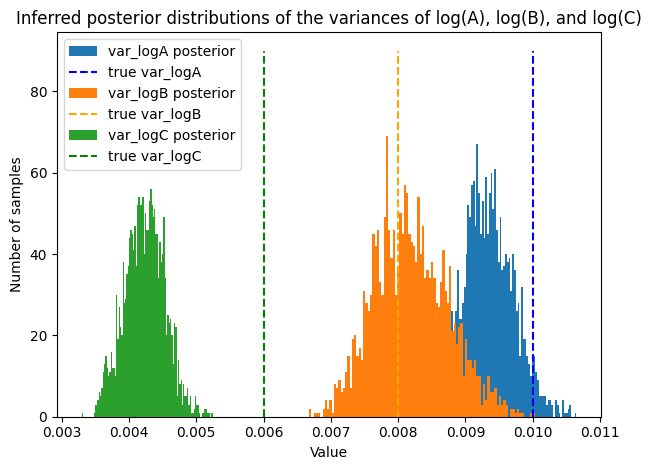

In [ ]:
var_logA = samples['var_logA']
var_logB = samples['var_logB']
var_logC = samples['var_logC']
plt.hist(var_logA, bins=100, label='var_logA posterior')
plt.vlines(true_log_var[0], 0, 90, colors='blue', linestyles='dashed', label='true var_logA')
plt.hist(var_logB, bins=100, label='var_logB posterior')
plt.vlines(true_log_var[1], 0, 90, colors='orange', linestyles='dashed', label='true var_logB')
plt.hist(var_logC, bins=100, label='var_logC posterior')
plt.vlines(true_log_var[2], 0, 90, colors='green', linestyles='dashed', label='true var_logC')
plt.title('Inferred posterior distributions of the variances of log(A), log(B), and log(C)')
plt.xlabel('Value')
plt.ylabel('Number of samples')
plt.legend()
plt.tight_layout()
plt.show()

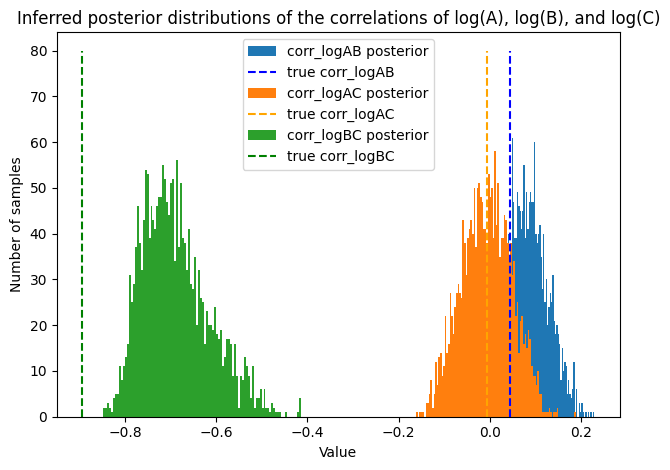

In [ ]:
corr_logAB = samples['corr_logAB']
corr_logAC = samples['corr_logAC']
corr_logBC = samples['corr_logBC']
plt.hist(corr_logAB, bins=100, label='corr_logAB posterior')
plt.vlines(true_corr[0, 1], 0, 80, colors='blue', linestyles='dashed', label='true corr_logAB')
plt.hist(corr_logAC, bins=100, label='corr_logAC posterior')
plt.vlines(true_corr[0, 2], 0, 80, colors='orange', linestyles='dashed', label='true corr_logAC')
plt.hist(corr_logBC, bins=100, label='corr_logBC posterior')
plt.vlines(true_corr[1, 2], 0, 80, colors='green', linestyles='dashed', label='true corr_logBC')
plt.title('Inferred posterior distributions of the correlations of log(A), log(B), and log(C)')
plt.xlabel('Value')
plt.ylabel('Number of samples')
plt.legend()
plt.tight_layout()
plt.show()